In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import time
import random

# For preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split 

# For LSTM model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

# For FOPDT model
from scipy.integrate import odeint

# For hyperopt (parameter optimization)
# ! pip install hyperopt
from hyperopt import Trials, STATUS_OK, tpe, fmin, hp

In [2]:
# Define functions to generate FOPDT model data
def fopdt(y,t,um,Km,taum):
    # arguments
    #  y      = output
    #  t      = time
    #  uf     = input linear function (for time shift)
    #  Km     = model gain
    #  taum   = model time constant
    # calculate derivative
    dydt = (-(y-yp0) + Km * (um-u0))/taum
    return dydt

# simulate simple model with x=[Km,taum]
def sim_model(Km,taum):
    # array for model values
    ym = np.zeros(ns)
    # initial condition
    ym[0] = yp0
    # loop through time steps    
    for i in range(0,ns-1):
        ts = [t[i],t[i+1]]
        y1 = odeint(fopdt,ym[i],ts,args=(u[i],Km,taum))
        ym[i+1] = y1[-1]
    return ym

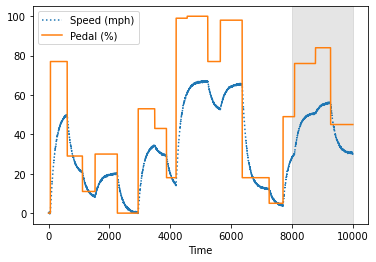

In [3]:
# Parameters and time for FOPDT model
ns = 10000
t = np.linspace(0,ns-1,ns)
u = np.zeros(ns)

# Additional FOPDT parameters
yp0 = 0.0
u0 = u[0]
Km = 0.67
taum = 160.0

# Generate step data for u
end = 60 # leave 1st minute of u as 0
while end <= ns:
    start = end
    end += random.randint(300,900) # keep new Q1s value for anywhere from 5 to 15 minutes
    u[start:end] = random.randint(0,100)

# Simulate FOPDT model
y = sim_model(Km,taum)

# Add Gaussian noise
noise = np.random.normal(0,0.2,ns)
y += noise

# Scale data
data = np.vstack((u,y)).T
s = MinMaxScaler(feature_range=(0,1))
data_s = s.fit_transform(data)

# Plot FOPDT model
plt.plot(y,':',label='Speed (mph)')
plt.plot(u,label='Pedal (%)')
plt.axvspan(ns-int(ns/5.0),ns,alpha=0.2,color='gray')
plt.xlabel('Time')
plt.legend();

In [4]:
def format_data(window=30):
    # arrange data to LSTM input and output with specified window
    X = []
    y = []
    for i in range(window,len(data_s)):
        X.append(data_s[i-window:i])
        y.append(data_s[i,1])
    
    # Format to array for LSTM input
    X, y = np.array(X), np.array(y)
    
    # Split into train and test
    Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,test_size=0.2,shuffle=False)        
    
    return Xtrain, ytrain, Xtest, ytest

In [5]:
window = 5

In [6]:
# Generate data with given window
Xtrain, ytrain, Xtest, ytest = format_data(window=window)
    
# Keras LSTM model
model = Sequential()
    
model.add(LSTM(units = 3, 
                input_shape = (Xtrain.shape[1],Xtrain.shape[2])
               )
          )
model.add(Dropout(rate = 0.3))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
    
es = EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=15)
result = model.fit(Xtrain, ytrain, verbose=0, validation_split=0.1,
                   batch_size=100,
                   epochs=200,
                   callbacks = [es]
                  )

Epoch 00078: early stopping


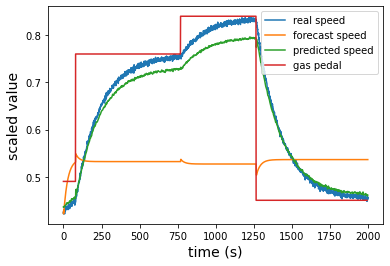

In [7]:
Yr = ytest
Yp = model.predict(Xtest)
Yf = ytest.copy()
for i in range(len(Yf)):
    if i < window:
        pass
    else:
        XQ = Xtest[i,:,0]
        XT = Yf[i-window:i]
        Xf = np.vstack((XQ,XT)).T
        Xf = np.reshape(Xf, (1, Xf.shape[0], Xf.shape[1])) 
        Yf[i] = model.predict(Xf)[0] 
        
plt.plot(Yr,label='real speed')
plt.plot(Yf,label='forecast speed')
plt.plot(Yp,label='predicted speed')
plt.plot(Xtest[window:,0,0],label='gas pedal')
plt.ylabel('scaled value',size=14)
plt.xlabel('time (s)',size=14)
plt.legend()